In [91]:
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from scipy.stats import norm
from root_numpy import root2array
from scipy.optimize import curve_fit
from lmfit import  Model #better gaussian model

In [111]:
# Do you want to write figures to png files? Careful, it will overwrite!
write_figures = True
figdir = 'Figures/'

In [93]:
#filedir = '/Users/davidkaleko/larlite/UserDev/KalekoAna/scratch_ana/mac/MCS_paper_anafiles/'
filedir = 'anafiles/'
#'SingleMuonRecoTrack'
#'MCBNBSelectedRecoTrack'
#'DataBNBSelectedRecoTrack'
#'MCBNBRecoTrack'
#'SingleMuonMCTrack'
anatype = 'MCBNBSelectedRecoTrack' 
!ls -ltra $filedir
seglen = 10
myfile = 'MCSBiasStudy_%s_anaout_%dcmseg_2res_bothscatters_nonrelfix.root' %( anatype, seglen )
print myfile

total 725952
-rw-r--r--   1 davidkaleko  staff    1118579 Nov 18 13:50 MCSBiasStudy_MCBNBSelectedRecoTrack_anaout_20cmseg_2res_bothscatters_nonrelfix.root
-rw-r--r--   1 davidkaleko  staff     388662 Nov 18 13:50 MCSBiasStudy_DataBNBSelectedRecoTrack_anaout_20cmseg_2res_bothscatters_nonrelfix.root
-rw-r--r--   1 davidkaleko  staff   10292241 Nov 18 13:51 MCSBiasStudy_MCBNBRecoTrack_anaout_20cmseg_2res_bothscatters_nonrelfix.root
-rw-r--r--   1 davidkaleko  staff     227369 Nov 18 15:31 MCSBiasStudy_SingleMuonRecoTrack_anaout_20cmseg_2res_bothscatters_nonrelfix.root
-rw-r--r--   1 davidkaleko  staff     544718 Nov 18 15:31 MCSBiasStudy_SingleMuonMCTrack_anaout_20cmseg_2res_bothscatters_nonrelfix.root
-rw-r--r--   1 davidkaleko  staff   45089107 Nov 18 22:09 MCSBiasStudy_MCBNBRecoTrack_anaout_5cmseg_2res_bothscatters_nonrelfix.root
-rw-r--r--   1 davidkaleko  staff   14051835 Nov 18 22:12 MCSBiasStudy_MCBNBRecoTrack_anaout_15cmseg_2res_bothscatters_nonrelfix.root
-rw-r--r--   1 davidkale

In [94]:
titles = { 
           'SingleMuonMCTrack'        : 'Fully Contained Single Muon MCTracks',
           'SingleMuonRecoTrack'      : 'Fully Contained, Well Reconstructed Single Muon Tracks',
           'DataBNBSelectedRecoTrack' : 'Selected, Well Reconstructed Tracks from NumuCC Data',
           'MCBNBSelectedRecoTrack'   : 'Selected, Well Reconstructed Tracks from NumuCC Simulation',
           'MCBNBRecoTrack'           : 'MC numuCC BNB Truth-Selected, Well Reconstructed Tracks',
           'full_MCS_energy'          : 'MCS Total Energy [GeV]',
           'full_range_energy'        : 'Range-Based Total Energy [GeV]',
           'full_MCS_momentum'        : 'MCS Momentum [GeV]',
           'full_range_momentum'      : 'Range-Based Momentum [GeV]',
           'true_E'                   : 'True Total Energy [GeV]'
         }

latextitles = {
           'full_range_energy'   : 'E_{Range}',
           'full_range_momentum' : 'p_{Range}',
           'full_MCS_energy'     : 'E_{MCS}',
           'full_MCS_momentum'   : 'p_{MCS}',
           'true_E'              : 'E_{True}'
         }

In [95]:
#This df has track-by-track information (MCS energy, range energy, etc)
df = pd.DataFrame( root2array ( filedir + myfile, 'MCS_bias_tree' ) )
#df['full_MCS_energy_inverse'] = 1./df['full_MCS_energy']
#df['full_range_energy_inverse'] = 1./df['full_range_energy']

#This df has segment-by-segment deviation (scattering angle, etc)
segdf = pd.DataFrame(  root2array ( filedir + myfile, 'TMC_debug_tree' ) )
segdf['dthetayoverpredictedRMS'] = segdf['delta_theta_y']/segdf['predicted_RMS']
segdf['dthetayovertruepredictedRMS'] = segdf['delta_theta_y']/segdf['true_predicted_RMS']
segdf['dthetayoverpredictedRMS_fromMCS'] = segdf['delta_theta_y']/segdf['predicted_RMS_fromMCS']

segdf['dthetaxoverpredictedRMS'] = segdf['delta_theta_x']/segdf['predicted_RMS']
segdf['dthetaxovertruepredictedRMS'] = segdf['delta_theta_x']/segdf['true_predicted_RMS']
segdf['dthetaxoverpredictedRMS_fromMCS'] = segdf['delta_theta_x']/segdf['predicted_RMS_fromMCS']


#Optional driver DF tree that holds some MCTrack informationß
driverdf = pd.DataFrame( root2array ( filedir + myfile, 'driver_tree' ) )

#Merge it into the main df by run,subrun,eventid
df = df.merge(driverdf, on=['run','subrun','eventid'])
#also merge into segdf
segdf = segdf.merge(driverdf, on=['run','subrun','eventid'])
print len(segdf)

28877


In [96]:
def gaussian(x, amp, cen, wid):
    "1-d gaussian: gaussian(x, amp, cen, wid)"
    return (amp/(np.sqrt(2*np.pi)*wid)) * np.exp(-(x-cen)**2 /(2*wid**2))

In [97]:
print df.columns.values

['full_length' 'full_range_energy' 'full_range_momentum' 'full_MCS_energy'
 'full_MCS_momentum' 'true_E' 'run' 'subrun' 'eventid' 'MCT_PDG'
 'MCT_origin']


In [98]:
def basic_comparison_fig(xvar, yvar, plotname =None, extraquery = None, addtext = None):
    plt.figure(figsize=(10,6)) 
    myquery = 'true_E < 99999999'
    if extraquery is not None: myquery += ' and %s'%extraquery
    myx = df.query(myquery)[xvar].values
    myy = df.query(myquery)[yvar].values
    blah = plt.hist2d(myx,myy,bins=((np.linspace(0,2,50),np.linspace(0,2,50))),cmin=1)
    blah = plt.colorbar()
    blah = plt.grid(True)
    blha = plt.xlabel('%s'%titles[xvar],fontsize=16)
    blha = plt.ylabel('%s'%titles[yvar],fontsize=16)
    blha = plt.title('%s'%titles[anatype],fontsize=16)
    blha.set_y(1.04)
    blah = plt.plot([0,100],[0,100],'g--',linewidth=3)
    
    if addtext is not None:
        plt.text(plt.xlim()[1]*0.6, plt.ylim()[1]*0.1, addtext, fontsize=20)
        
    if write_figures:
        if plotname is not None: 
            print "Saving figure %s"%plotname
            plt.tight_layout()
            plt.savefig(figdir + plotname)
        else: print "YOU WANTED TO SAVE A PLOT BUT DIDN'T GIVE A PLOT NAME!"

Saving figure MCS_range_comparison_MCBNBSelectedRecoTrack.png


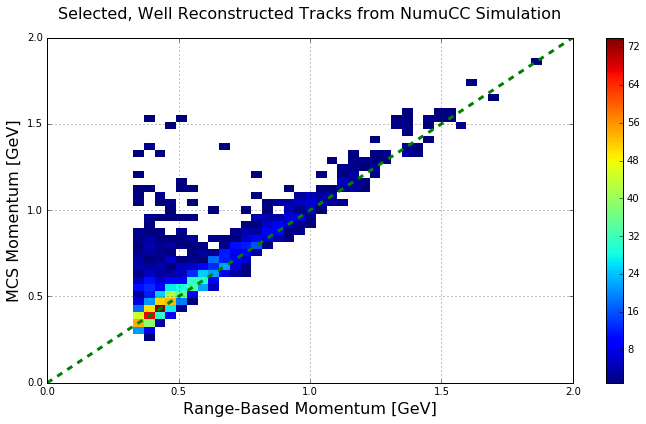

In [99]:
# MCS momentum vs range momentum for all samples
basic_comparison_fig(xvar='full_range_momentum',yvar='full_MCS_momentum',
                         plotname='MCS_range_comparison_%s.png'%anatype)

In [100]:
# Range energy vs True Energy for single muon MCTrack analysis only
if anatype == 'SingleMuonMCTrack':
    basic_comparison_fig(xvar='true_E',yvar='full_range_energy',
                         plotname='true_range_comparison_MCTracks.png')


Saving figure MCS_range_momentum_MCBNBSelectedRecoTrack_211.png
Saving figure MCS_range_momentum_MCBNBSelectedRecoTrack_13.png
Saving figure MCS_range_momentum_MCBNBSelectedRecoTrack_2212.png
Saving figure  MCBNBSelectedRecoTrack_MID_piechart.png


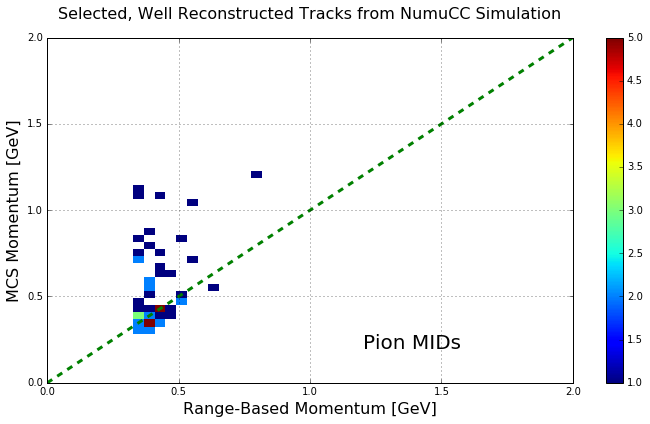

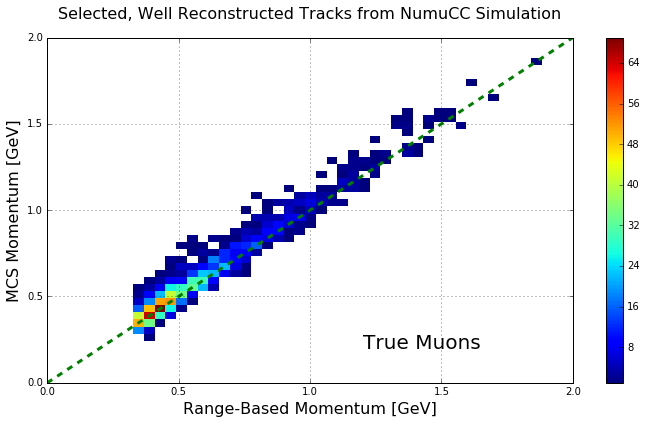

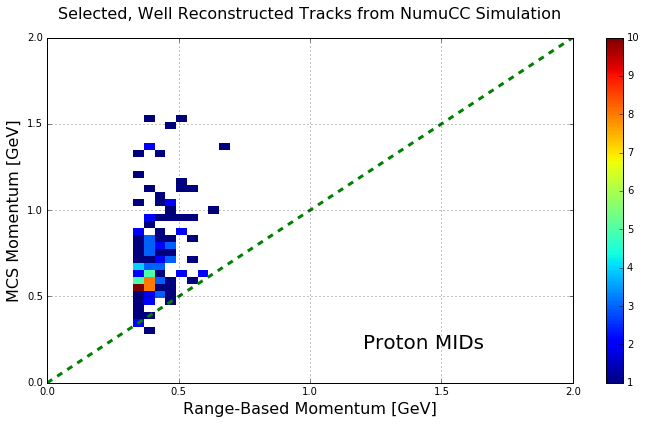

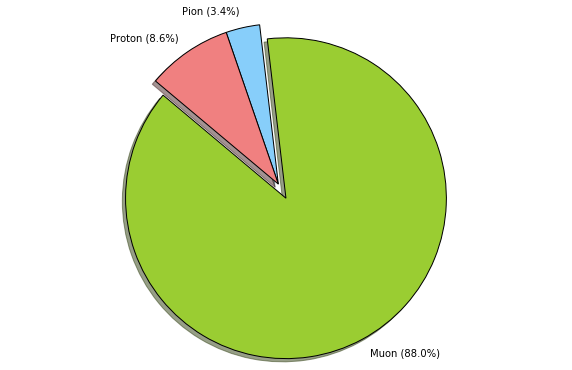

In [113]:
#Breakdown of proton, pion MIDs and true muon IDs
if anatype == 'MCBNBSelectedRecoTrack':

    for (pdg,name) in [ (211,'Pion MIDs'), (13,'True Muons'), (2212, 'Proton MIDs')]:
        
        #Testing this way
        extraquery = 'MCT_PDG == %d or MCT_PDG == -%d'%(pdg,pdg)
        basic_comparison_fig(xvar='full_range_momentum',yvar='full_MCS_momentum',
                         plotname='MCS_range_momentum_MCBNBSelectedRecoTrack_%d.png' % pdg,
                            extraquery = extraquery,
                            addtext = name)
    # Pie chart!

    plt.figure(figsize=(10,6))
    
    sizes = [ len(df.query('MCT_PDG == %d or MCT_PDG == -%d'%(13,13))),
              len(df.query('MCT_PDG == %d or MCT_PDG == -%d'%(211,211))),
              len(df.query('MCT_PDG == %d or MCT_PDG == -%d'%(2212,2212))) ]
    total = float(np.sum(sizes))
    labels = ['Muon (%0.1f%%)' % (100.*(sizes[0]/total)), 
              'Pion (%0.1f%%)' % (100.*(sizes[1]/total)), 
              'Proton (%0.1f%%)' % (100.*(sizes[2]/total))]
    colors = ['yellowgreen', 'lightskyblue', 'lightcoral']
 
    explode = (0.1, 0, 0)  # explode muon slice
 
    # Plot
    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
            shadow=True, startangle=140)
     
    plt.axis('equal')
    if write_figures:
        print "Saving figure",'MCBNBSelectedRecoTrack_MID_piechart.png'
        plt.savefig(figdir+'MCBNBSelectedRecoTrack_MID_piechart.png')
    

In [78]:
#Read in handscan info if working with data
if anatype == 'DataBNBSelectedRecoTrack':
    filedir = 'handscan_results/'
    myfile = 'handscan_results_kaleko.csv'
    
    hsdf = pd.read_csv(filedir + myfile,index_col=False)
       
    #Column names with spaces are hard to deal with, this is easy
    cols = hsdf.columns
    cols = cols.map(lambda x: x.replace(' ', '_') if isinstance(x, (str, unicode)) else x)
    hsdf.columns = cols
    
    #If no optional comments were typed in it shows up as NaN
    #Let's just make a column of "optional comments present" (boolean)
    
    hsdf['comments_present'] = hsdf['optional_comments'].notnull()
    
    #Let's rename things... 1_good_0_bad is only 0 if the track is definitely bad
    hsdf['definitely_bad'] = hsdf['1_good_0_bad'] == 0
    
    #maybe bad is either definitely_bad, or if comments are present (more conservative)
    hsdf['maybe_bad'] = hsdf['definitely_bad'] | hsdf['comments_present']
    
    print "total length of hsdf is",len(hsdf)
    print "number of definitely bad is",len(hsdf.query('definitely_bad'))
    print "number of maybe bad is",len(hsdf.query('maybe_bad'))
    
    #let's rename run, subrun, eventid columns to match the MCS df
    #for now just make a new column because it's easier
    hsdf['run'] = hsdf['Run']
    hsdf['subrun'] = hsdf['Subrun']
    hsdf['eventid'] = hsdf['Event_ID']
    
    df = df.merge(hsdf, on=['run','subrun','eventid'])

    segdf = segdf.merge(hsdf, on=['run','subrun','eventid'])

In [79]:
#Breakdown of events that were handscanned as good, and those handscanned as bad
if anatype == 'DataBNBSelectedRecoTrack':

    extraquery = 'not maybe_bad'
    basic_comparison_fig(xvar='full_range_momentum',yvar='full_MCS_momentum',
                         plotname='MCS_range_momentum_DataRecoTracks_goodhandscan.png',
                            extraquery = extraquery,
                        addtext = 'Good Scan Sample')
    
    extraquery = 'maybe_bad'
    basic_comparison_fig(xvar='full_range_momentum',yvar='full_MCS_momentum',
                         plotname='MCS_range_momentum_DataRecoTracks_badhandscan.png',
                            extraquery = extraquery,
                        addtext = 'Bad Scan Sample')

In [80]:
#mybins = (np.linspace(0,2,50),np.linspace(0,2,50))
#plt.figure(figsize=(10,6))
#myx = df['full_range_momentum'].values
#myy = df['full_MCS_momentum'].values
#blah = plt.hist2d(myx,myy,bins=mybins,cmin=1)
#blah = plt.colorbar()
#blah = plt.grid(True)
#blha = plt.xlabel('Range-Based Momentum [GeV]',fontsize=16)
#blha = plt.ylabel('MCS Momentum [GeV]',fontsize=16)
#blha = plt.title('%s'%titles[anatype],fontsize=16)
##blha = plt.title('Selected, Contained Muons in BNB Data',fontsize=16)
#blha.set_y(1.04)
#blah = plt.plot([0,100],[0,100],'g--',linewidth=3)
#
#if anatype == 'DataBNBSelectedRecoTrack':
#    myquery = 'not definitely_bad'
#    plt.figure(figsize=(10,6))
#    myx = df.query(myquery)['full_range_energy'].values
#    myy = df.query(myquery)['full_MCS_energy'].values
#    blah = plt.hist2d(myx,myy,bins=mybins,cmin=1)
#    blah = plt.colorbar()
#    blah = plt.grid(True)
#    blha = plt.xlabel('Range-Based Total Energy [GeV]',fontsize=16)
#    blha = plt.ylabel('MCS Total Energy [GeV]',fontsize=16)
#    blha = plt.title('Selected, Contained Muons in BNB Data',fontsize=16)
#    blah = plt.plot([0,100],[0,100],'g--',linewidth=5)
#    
#    myquery = 'not maybe_bad'
#    plt.figure(figsize=(10,6))
#    myx = df.query(myquery)['full_range_energy'].values
#    myy = df.query(myquery)['full_MCS_energy'].values
#    blah = plt.hist2d(myx,myy,bins=mybins,cmin=1)
#    blah = plt.colorbar()
#    blah = plt.grid(True)
#    blha = plt.xlabel('Range-Based Total Energy [GeV]',fontsize=16)
#    blha = plt.ylabel('MCS Total Energy [GeV]',fontsize=16)
#    blha = plt.title('Selected, Contained Muons in BNB Data',fontsize=16)
#    blha = plt.title('Selected, Contained Muons in BNB Data [Well Reconstructed]',fontsize=16)
#    blha.set_y(1.04)
#    blah = plt.plot([0,100],[0,100],'g--',linewidth=5)
#

In [81]:
#reco-true/true
def icarus_plot(extraquery = None):
    binning = np.linspace(0.35,1,10)
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)
    myreses, mystds, myerrs = [], [], []

    for x in xrange(len(binning)-1):
        
        binmin = binning[x]
        binmax = binning[x+1]
        #print "binmin = %0.2f, binmax = %0.2f"% ( binmin, binmax )
        myquery = 'full_range_energy > %f and full_range_energy < %f'%(binmin,binmax)
        if anatype == 'singletrack_data': myquery += ' and not maybe_bad'
        if extraquery is not None: myquery += ' and %s' % extraquery
        mydf = df.query(myquery)
        true = mydf['full_range_energy'].values
        reco = mydf['full_MCS_energy'].values
        mymean = ((reco-true)/true).mean()
        mystd = ((reco-true)/true).std()
        myerr = mystd / np.sqrt( float(len(true)) )
        myreses.append( mymean )
        mystds.append( mystd )
        myerrs.append( myerr )
            
    plt.figure(figsize=(10,6))
    plt.errorbar(bincenters[:-1],myreses,yerr=mystds,fmt='o--',label='Mean of Distribution, Errors = std')
    plt.ylabel('mean($\\frac{E_{MCS} - E_{Range}}{E_{Range}}$)',fontsize=25)
    plt.xlabel('Range-Based Total Energy [GeV]',fontsize=15)
    plt.grid(True)
    plt.legend(loc='best')
    t = plt.title('MCS Dispersion: %s'%titles[anatype],fontsize=16)
    t.set_y(1.04)

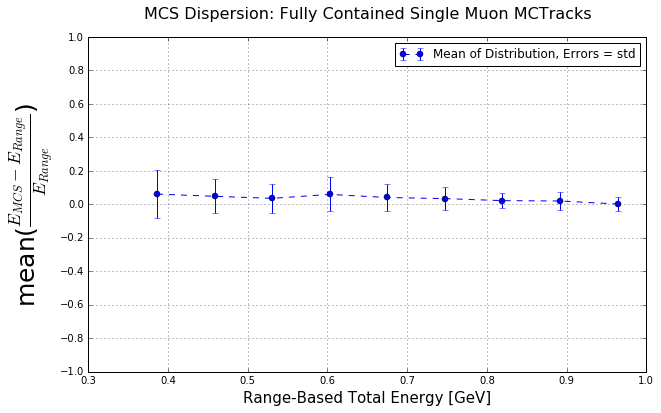

In [82]:
icarus_plot(extraquery='MCT_PDG == 13 or MCT_PDG == -13')
blah = plt.ylim((-1,1))
blah = plt.yticks(np.arange(-1, +1.1, .20))

In [83]:
def highlandE(rms):
    loverX = float(seglen)/14.
    return np.sqrt((13.6*13.6*loverX*np.square((1+0.038*np.log(loverX))))/np.square(rms))

In [84]:
segdf.columns.values

array(['full_track_len', 'full_MCS_E', 'full_range_E', 'delta_theta_x',
       'delta_theta_y', 'seg_end_x', 'seg_end_y', 'seg_end_z',
       'n_traj_points', 'seg_theta', 'seg_phi', 'counter',
       'true_segment_E', 'true_predicted_RMS', 'segment_E',
       'predicted_RMS', 'segment_E_fromMCS', 'predicted_RMS_fromMCS',
       'resid_dist', 'llbf', 'run', 'subrun', 'eventid',
       'dthetayoverpredictedRMS', 'dthetayovertruepredictedRMS',
       'dthetayoverpredictedRMS_fromMCS', 'dthetaxoverpredictedRMS',
       'dthetaxovertruepredictedRMS', 'dthetaxoverpredictedRMS_fromMCS',
       'MCT_PDG', 'MCT_origin'], dtype=object)

In [85]:
def deflection_plot(binmin,binmax,nbins,extraquery=None,plotname=None):
    
    fig = plt.figure(figsize=(10,6))
    
    poop = plt.grid(True)
    
    myquery = 'run < 99999999'
    if extraquery is not None: myquery += ' and %s'%extraquery
    print myquery
    mybins = np.linspace(binmin,binmax,nbins)
    
    myvar1 = 'dthetayoverpredictedRMS_fromMCS'
    myvar2 = 'dthetaxoverpredictedRMS_fromMCS'

    myvals = np.append(
        segdf.query(myquery).\
        query('%s > %f and %s < %f'%(myvar1,binmin,myvar1,binmax))[myvar1].values,
        segdf.query(myquery).\
        query('%s > %f and %s < %f'%(myvar2,binmin,myvar2,binmax))[myvar2].values
    )
        
    mystd = np.std(myvals)
    mymean = np.mean(myvals)

    datahist = plt.hist(myvals,bins=mybins,normed=True,
                             alpha=0.5,label='$\Delta\\theta/RMS$ Values')#,
                            #weights = myweights)
   
    datahist_nonorm = np.histogram(myvals,bins=mybins,normed=False)
    
    binvals = datahist[0]
    bincenters = [ datahist[1][x] + (datahist[1][x+1]-datahist[1][x])/2 for x in xrange(len(datahist[1])-1) ]
    
    # Fit a normal distribution
    gmod = Model(gaussian)
    #initial random guesses of 1, 1, 2
    result = gmod.fit(binvals, x=bincenters, amp=1, cen=1, wid=2)

    #print(result.fit_report())
    #print help(result)
    #plt.plot(bincenters, binvals,         'bo')
    #plt.plot(bincenters, result.init_fit, 'k--')
    print result.params
    plt.plot(bincenters, result.best_fit, 'g-',\
             label='Gaussian Fit: $\sigma$ = %0.2f' % result.params['wid'],\
            linewidth=4)
  
    #data_mu, data_std = norm.fit(myvals)
    
    #myhighland = highlandE(data_std)

    # Plot the PDF.
    #x = np.linspace(binmin,binmax,100)
    #p = norm.pdf(x, data_mu, data_std)
    #plt.plot(x, p, 'g', linewidth=4,label='Gaussian Fit to Data')
    
    
    plt.title('%s'%titles[anatype],fontsize=14)
   
    plt.xlabel('Delta Theta / RMS',fontsize=16)
    blah = plt.legend(loc='best')
    leg = plt.legend(loc=2)
    
    if write_figures:
        fullfigname = figdir + 'Highland_validation_%s.png' % anatype
        print "\n\n WRITING FIGURE %s! \n\n"%fullfigname
        plt.tight_layout()
        if plotname is not None: plt.savefig(figdir + plotname)
        else: plt.savefig(fullfigname)

run < 99999999
Parameters([('amp', <Parameter 'amp', value=0.97231174692705824 +/- 0.00998, bounds=[-inf:inf]>), ('cen', <Parameter 'cen', value=-4.8823741392569566e-05 +/- 0.0114, bounds=[-inf:inf]>), ('wid', <Parameter 'wid', value=0.96489006795344068 +/- 0.0114, bounds=[-inf:inf]>)])


 WRITING FIGURE Figures/Highland_validation_SingleMuonMCTrack.png! 




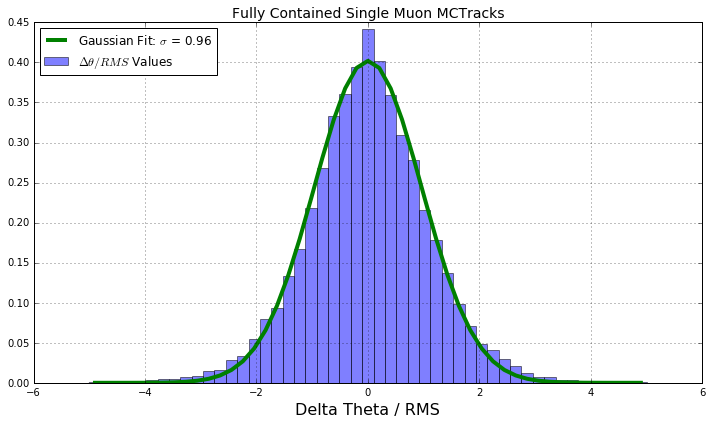

In [86]:
# For MCBNBSelectedRecoTrack only make highland validation plot for the true muons
myextraquery = None
if anatype == 'MCBNBSelectedRecoTrack':
    myextraquery = 'MCT_PDG == 13 or MCT_PDG == -13'
# For real data events, only make plot for those events handscanned as "good"
if anatype == 'DataBNBSelectedRecoTrack':
    myextraquery = 'not maybe_bad'
    
dummy = deflection_plot(-5,5,50,extraquery=myextraquery)


In [87]:
#reco-true/true
def fractional_bias_plot(xvar = 'full_range_momentum', xbins = np.linspace(0.35,1,10),
                   yvar = 'full_MCS_momentum', slicevar = 'full_range_momentum',
                         plot_bin_distributions = False, extraquery = None, slicetitlebase = None,
                        slicebins = np.linspace(-0.8,.8,20),
                        plotname = None, mainfig_ylims = None):

    binning = xbins
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)
    myreses, mystds, myerrs = [], [], []

    for x in xrange(len(binning)-1):
        
        binmin = binning[x]
        binmax = binning[x+1]
        #print "binmin = %0.2f, binmax = %0.2f"% ( binmin, binmax )
        myquery = '%s > %f and %s < %f'%(slicevar,binmin,slicevar,binmax)
        if anatype == 'singletrack_data': 
            myquery += ' and not maybe_bad'
        if extraquery is not None:
            myquery += ' and %s' % extraquery
            
        mydf = df.query(myquery)
        true = mydf[xvar].values
        reco = mydf[yvar].values
        mymean = ((reco-true)/true).mean()
        mystd = ((reco-true)/true).std()
        myerr = mystd / np.sqrt( float(len(true)) )
        myreses.append( mymean )
        mystds.append( mystd )
        myerrs.append( myerr )
        
        if plot_bin_distributions:
            plt.figure(figsize=(5,3))
            plt.hist((reco-true)/true,color='r',alpha=0.5,label='%d Entries'%len((reco-true)/true),\
                     bins=slicebins)
            titlestring = '$\\frac{%s - %s}{%s}$ for $%s$ in %0.2f $\\rightarrow$ %0.2f GeV'% \
            (latextitles[yvar],latextitles[xvar],latextitles[xvar],latextitles[slicevar],binmin,binmax)
            t =plt.title(titlestring,fontsize=16)
            #move the title up a bit
            t.set_y(1.04) 
            plt.grid(True)
            
            plt.xlabel('$\\frac{%s - %s}{%s}$'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=16)
            plt.ylabel('Counts',fontsize=16)
            plt.xlim((np.min(slicebins),np.max(slicebins)))
            plt.legend(loc=1)
            if write_figures and slicetitlebase is not None:
                fullfigname = figdir + slicetitlebase + '_slice_%0.2f_%0.2f.png'%(binmin,binmax)
                print '\n\n WRITING A FIGURE!! %s\n\n'%fullfigname
                plt.tight_layout()
                plt.savefig(fullfigname)
            
    plt.figure(figsize=(10,6))
    plt.errorbar(bincenters[:-1],myreses,yerr=myerrs,fmt='ro--',label='Mean of Distribution, Errors = std/sqrt(N)')
    plt.ylabel('mean($\\frac{%s - %s}{%s}$)'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=25)
    plt.xlabel('%s'%titles[xvar],fontsize=15)
    plt.grid(True)
    plt.legend(loc='best')
    t = plt.title('Fractional Bias: %s'%titles[anatype],fontsize=16)
    t.set_y(1.04)
    if mainfig_ylims is not None:
        blah = plt.ylim(mainfig_ylims)
    if write_figures and plotname is not None:
        print " \n\n Writing the main figure!! %s\n\n" % (figdir+plotname)
        plt.tight_layout()
        plt.savefig(figdir + plotname)



 WRITING A FIGURE!! Figures/true_range_resolution_SingleMuonMCTrack_slice_0.35_0.53.png




 WRITING A FIGURE!! Figures/true_range_resolution_SingleMuonMCTrack_slice_0.53_0.72.png




 WRITING A FIGURE!! Figures/true_range_resolution_SingleMuonMCTrack_slice_0.72_0.90.png




 WRITING A FIGURE!! Figures/true_range_resolution_SingleMuonMCTrack_slice_0.90_1.08.png




 WRITING A FIGURE!! Figures/true_range_resolution_SingleMuonMCTrack_slice_1.08_1.27.png




 WRITING A FIGURE!! Figures/true_range_resolution_SingleMuonMCTrack_slice_1.27_1.45.png




 WRITING A FIGURE!! Figures/true_range_resolution_SingleMuonMCTrack_slice_1.45_1.63.png




 WRITING A FIGURE!! Figures/true_range_resolution_SingleMuonMCTrack_slice_1.63_1.82.png




 WRITING A FIGURE!! Figures/true_range_resolution_SingleMuonMCTrack_slice_1.82_2.00.png


 

 Writing the main figure!! Figures/true_range_bias_SingleMuonMCTrack.png




 WRITING A FIGURE!! Figures/MCS_range_resolution_SingleMuonMCTrack_slice_0.35_0.53.png




 

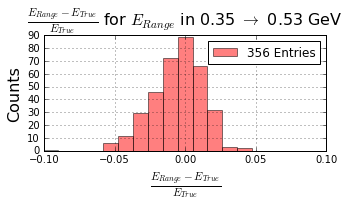

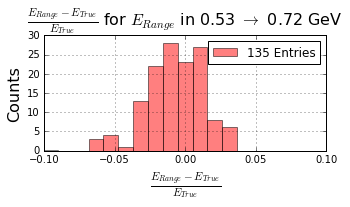

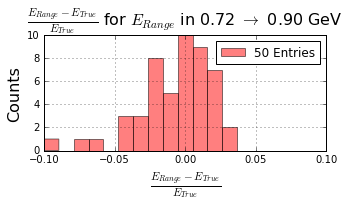

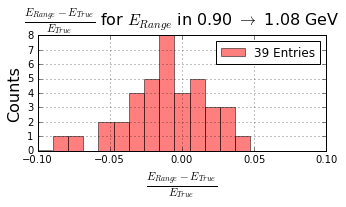

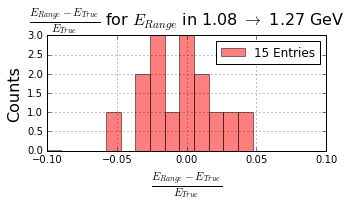

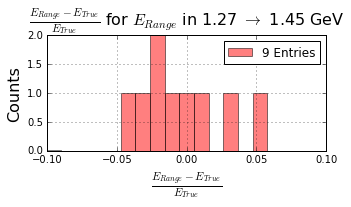

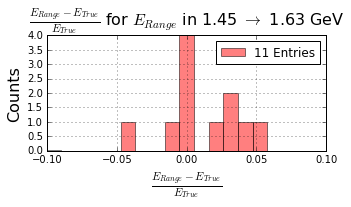

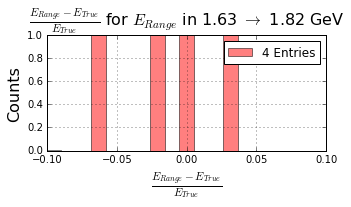

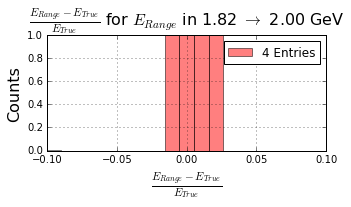

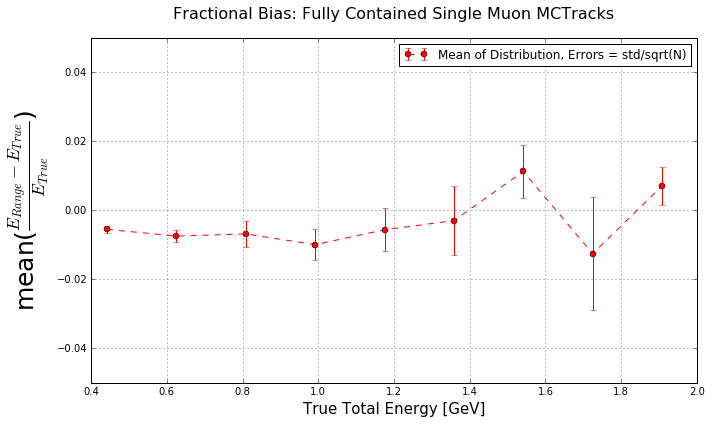

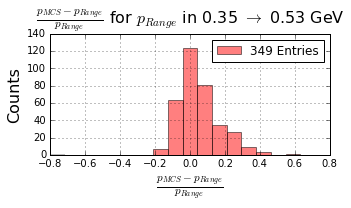

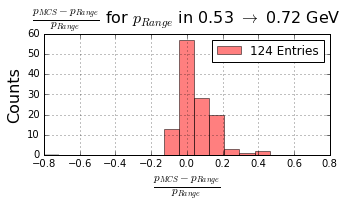

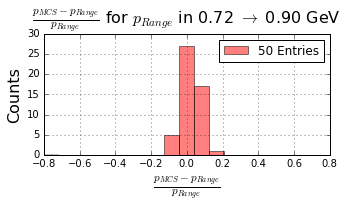

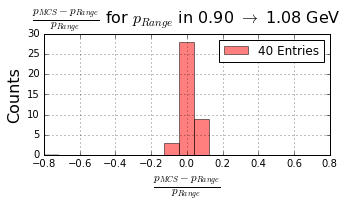

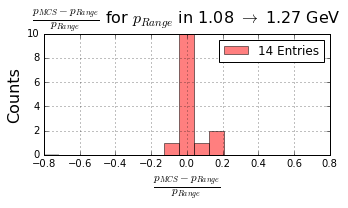

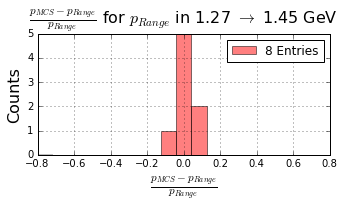

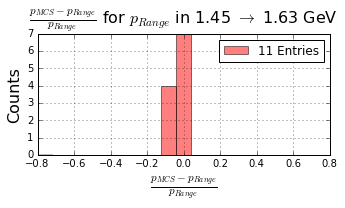

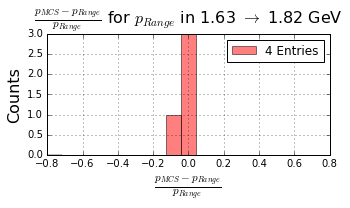

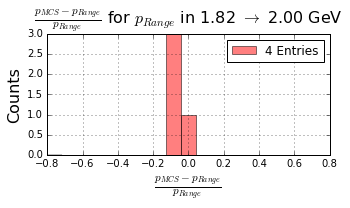

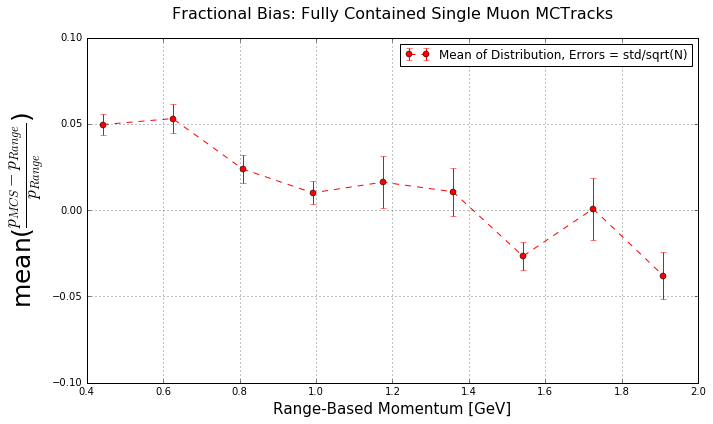

In [88]:
# Fractional bias plot for True vs Range energy for single MCTrack section only
if anatype == 'SingleMuonMCTrack':
    fractional_bias_plot(xvar='true_E',yvar='full_range_energy',xbins=np.linspace(0.35,2,10),
                       plot_bin_distributions = True,
                       slicevar = 'full_range_energy',
                       slicetitlebase = 'true_range_resolution_%s'%anatype,
                       slicebins = np.linspace(-0.1,0.1,20),
                       plotname = 'true_range_bias_%s.png'%anatype,
                       mainfig_ylims = (-.05,.05))

# Nominal fractional bias plot for all samples
# For MCBNBSelectedRecoTrack only make plot for the true muons
myextraquery = None
if anatype == 'MCBNBSelectedRecoTrack':
    myextraquery = 'MCT_PDG == 13 or MCT_PDG == -13'
# For real data events, only make plot for those events handscanned as "good"
if anatype == 'DataBNBSelectedRecoTrack':
    myextraquery = 'not maybe_bad'
    
fractional_bias_plot(xvar='full_range_momentum',yvar='full_MCS_momentum',xbins=np.linspace(0.35,2,10),
                       plot_bin_distributions = True,
                       slicevar = 'full_range_momentum',
                       extraquery = myextraquery,
                       slicetitlebase = 'MCS_range_resolution_%s'%anatype,
                       slicebins = np.linspace(-0.8,0.8,20),
                       plotname = 'MCS_range_bias_%s.png'%anatype,
                       mainfig_ylims = (-.10,.10))

#fractional_bias_plot(xvar='full_range_energy',xbins=np.linspace(0.35,2,10),
#                    plot_bin_distributions = True)
#blah = plt.ylim((-.1,.1))

#fractional_bias_plot(yvar='full_range_momentum',xbins=np.linspace(0.35,2,10),
#                     xvar='full_MCS_momentum',
#                    plot_bin_distributions = True)
#blah = plt.ylim((-.1,.1))


In [89]:
#Here I fit the resolution to a realistic resolution equation
def res_eqtn(E,a,b,c):
    return np.sqrt(np.square(a/np.sqrt(E)) + np.square(b/E) + np.square(c))

#def res_eqtn(x,a):
#    return a/np.sqrt(x)

#def res_eqtn(E,a,b,c):
#    return np.sqrt(np.square(a/np.sqrt(1./E)) + np.square(b/(1./E)) + np.square(c))


#reco-true/true
def resolution_plot(xvar = 'full_range_momentum', xbins = np.linspace(0.35,1,10),
                   yvar = 'full_MCS_momentum', slicevar = 'full_range_momentum',
                         extraquery = None,
                        plotname = None, mainfig_ylims = None):
    
    #This includes a fit to a realistic resolution equation
    
    binning = xbins
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)
    myreses, mystds, myerrs = [], [], []
    myN = []
    for x in xrange(len(binning)-1):
        
        binmin = binning[x]
        binmax = binning[x+1]
        #print "binmin = %0.2f, binmax = %0.2f"% ( binmin, binmax )
        myquery = '%s > %f and %s < %f'%(slicevar,binmin,slicevar,binmax)
        if anatype == 'singletrack_data':
            myquery += ' and not maybe_bad'
        if extraquery is not None:
            myquery += ' and %s' % extraquery
            
        mydf = df.query(myquery)
        true = mydf[xvar].values
        reco = mydf[yvar].values
        mymean = ((reco-true)/true).mean()
        mystd = ((reco-true)/true).std()
        #Error of standard deviation is sigma/sqrt(2N)
        myerr = mystd / np.sqrt( 2 * float(len(true)) )
        myN.append(len(true))
        myreses.append( mymean )
        mystds.append( mystd )
        myerrs.append( myerr )
            
    plt.figure(figsize=(10,6))
    plt.errorbar(bincenters[:-1],mystds,yerr=myerrs,fmt='o--',label='Std of Distribution, Errors = std/sqrt(2N)')
    plt.ylabel('std($\\frac{%s - %s}{%s}$)'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=25)
    plt.xlabel('%s'%titles[xvar],fontsize=15)
    plt.grid(True)
    t = plt.title('Momentum Resolution: %s' % titles[anatype],fontsize=16)
    #move the title up a bit
    t.set_y(1.04) 
                    
    if mainfig_ylims is not None:
        blah = plt.ylim(mainfig_ylims)
    if write_figures and plotname is not None:
        print " \n\n Writing the main figure!! %s \n\n" % (figdir+plotname)
        plt.tight_layout()
        plt.savefig(figdir + plotname)
    
#     if draw_fit:
#         popt, pcov = curve_fit(res_eqtn, bincenters[:-1], mystds, sigma=myerrs)
        
#         fitx = np.linspace(0.35,1,100)
#         fity = res_eqtn(fitx,popt[0],popt[1],popt[2])
#         labelstring = 'Resolution Fit: '
#         labelstring += '$[\\frac{a}{\sqrt{E}} \circ \\frac{b}{E} \circ c]$'
#         plt.plot(fitx,fity,'r-',label=labelstring)
   
#         plt.legend(loc='best')
    
#         return popt, pcov
#     else:
#         plt.legend(loc='best')
#         return (-1, -1)

 

 Writing the main figure!! Figures/true_range_resolution_SingleMuonMCTrack.png 


 

 Writing the main figure!! Figures/MCS_range_resolution_SingleMuonMCTrack.png 




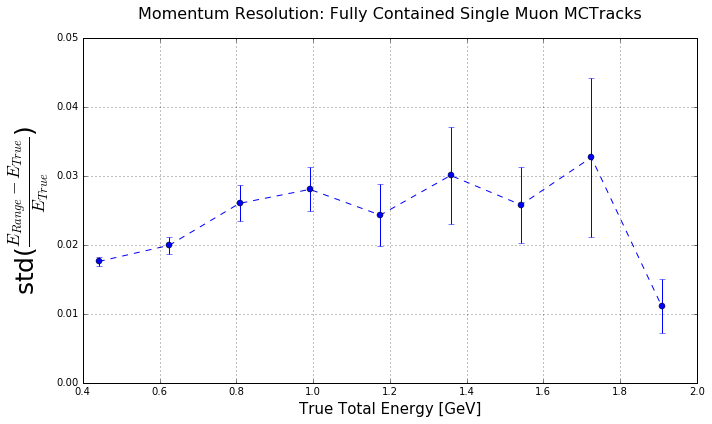

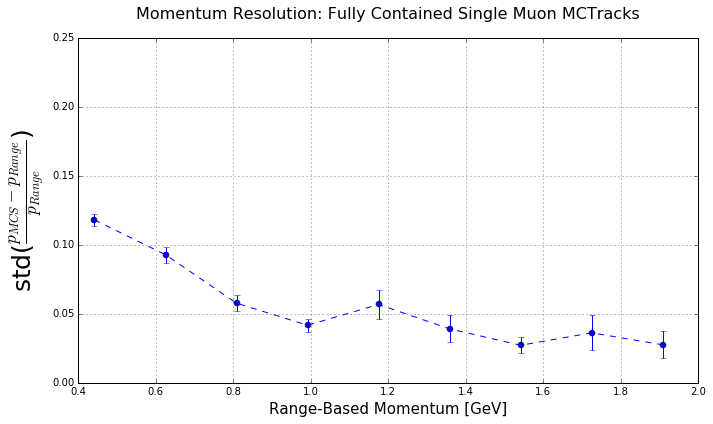

In [90]:
# Fractional resolution plot for True vs Range energy for single MCTrack section only
if anatype == 'SingleMuonMCTrack':
    resolution_plot(xvar='true_E',yvar='full_range_energy',xbins=np.linspace(0.35,2,10),
                       slicevar = 'full_range_energy',
                       plotname = 'true_range_resolution_%s.png'%anatype,
                       mainfig_ylims = (0,.05))
   
# Nominal fractional bias plot for all samples
# For MCBNBSelectedRecoTrack only plot for the true muons
myextraquery = None
if anatype == 'MCBNBSelectedRecoTrack':
    myextraquery = 'MCT_PDG == 13 or MCT_PDG == -13'
# For real data events, only make plot for those events handscanned as "good"
if anatype == 'DataBNBSelectedRecoTrack':
    myextraquery = 'not maybe_bad'
    
resolution_plot(xvar='full_range_momentum',yvar='full_MCS_momentum',xbins=np.linspace(0.35,2,10),
                       slicevar = 'full_range_momentum',
                       extraquery = myextraquery,
                       plotname = 'MCS_range_resolution_%s.png'%anatype,
                       mainfig_ylims = (0,.25))

#resolution_plot(xvar='true_E',draw_fit=False,yvar='full_range_energy',
#                                xbins=np.linspace(0.35,2,10))
#blah = plt.ylim((0,0.05))
#first, second = resolution_plot(xvar='true_E',draw_fit=False)
#blah = plt.ylim((0,0.4))
#first, second = resolution_plot(xvar='full_range_energy',draw_fit=False,xbins=np.linspace(0.35,2,10))
#blah = plt.ylim((0,0.25))

#first, second = resolution_plot(xvar='full_range_momentum',draw_fit=False,xbins=np.linspace(0.35,2,10),\
#                               extraquery = 'MCT_PDG == 13 or MCT_PDG == -13')
#blah = plt.ylim((0,0.25))